Выпускная квалификационная работа 
по курсу «Инженер данных Data engineer Pro

13393 Инженер данных PRO

НИКИТИНА МАРИНА ВАЛЕРЬЕВНА

Тема: 
Классификация госконтрактов по объектам закупки.


Задача: необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.
Группы могут быть следующим:

1.	Строительно-монтажные работы (СМР)
2.	Проектно-изыскательские работы (ПИР)
3.	Строительный надзор
4.	Подключение коммуникаций
5.	рочее.

По ОКПД-2 контракты в общем случае должны разделяться так:
Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
Проектно-изыскательские работы (ПИР) - 41.1, 71.1
Подключение коммуникаций - 43.22
Строительный надзор – четкогруппы нет.


Проблема: Далеко не всегда контракты указываются с нужным кодом, поэтому есть проблема как такие контракты "отловить" и определить  нужную группу.

Поэтому задача предполагает классификацию контрактов на основе объекта закупки, который сформулирован е
тественным языком. Также предполагаем, что могут иметь значение цена контракта и его длительность.
На основе этого на входе данные о контрактах. На выходе необходимо получить группу длякаждого контракта.

Иногда контракт может относиться одновремено в несколько групп.


Установка и подключение библиотек

In [1]:
! pip install pandas
! pip install seaborn

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import os
import gdown
import zipfile
import warnings

In [5]:
import nltk
import spacy
import joblib

In [6]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve, auc

Отключение предупреждений

In [8]:
warnings.filterwarnings('ignore')

Задача имени ZIP-файла со списком контрактов

In [9]:
name_zip = 'fz.zip'

Скачивание ZIP-файла со списком контрактов (2,6 Гб)

In [10]:
url = 'https://drive.google.com/file/d/1sRHx27O3NgTivrrQHdBdTAqxdCYNmARW/view?usp=sharing'
gdown.download(url, name_zip, quiet=False)

Downloading...
From: https://drive.google.com/file/d/1sRHx27O3NgTivrrQHdBdTAqxdCYNmARW/view?usp=sharing
To: C:\Users\User\fz.zip
92.2kB [00:00, 5.12MB/s]


'fz.zip'

Распаковка ZIP-файла со списком контрактов, размер CSV-файла ~ 26 Гб

In [11]:
with zipfile.ZipFile(name_zip, 'r') as zip_ref:
  zip_ref.extractall()

BadZipFile: File is not a zip file

Проверка наличия CSV-файла в каталоге и присвоение имени 

In [12]:
name_csv = None
for file in os.listdir():
  if file.endswith('.csv'):
    name_csv = file
    break

if name_csv is None:
  raise FileNotFoundError("В ZIP-архиве CSV-файл не найден")

In [13]:
df_original = pd.DataFrame()

Определение типов записей, необходимых для анализа

In [14]:
type_cols = {'contract_number': 'string', 'object_name': 'string', 'cost': 'string', 'object_code': 'string'}

Чтение данных из CSV-файла_больших_данных частями в датафрейм, параллельно удаляем столбцы и строки с пустыми значениями, примечания ниже 

In [15]:
with pd.read_csv(name_csv, chunksize=100000, encoding='utf-8', on_bad_lines="skip", delimiter=',', header=None, usecols=[1, 11, 20, 26], names=['contract_number', 'object_name', 'cost', 'object_code'], dtype=type_cols) as reader:
  for chunk in reader:
    # Отфильтровываем записи о контрактах, оставляя записи групп ОКПД2 41, 42, 43, 71.1
    chunk = chunk[(chunk['object_code'].str.len() <= 4) & (chunk['object_code'].str.contains('^41.') | chunk['object_code'].str.contains('^42.') | chunk['object_code'].str.contains('^43.') | chunk['object_code'].str.contains('^71.1'))]
   # Удаляем из датафрейма строки с неопределенным предметом закупки и строки с пустыми значениями
    chunk = chunk.loc[chunk['object_name'] != '<НЕ ОПРЕДЕЛЕНО>']
    chunk.dropna
    # Добавляем текущий chunk в итоговый большой датафрейм
    df_original = pd.concat([df_original, chunk], ignore_index=True)

Создание и предварительный анализ рабочего датафрейма

In [16]:
df_work = df_original

Сбрасывание индексов в нем

In [17]:
df_work = df_work.reset_index()
del df_work['index']

Выборка 5 случайных записей

In [18]:
df_work.sample(5)

,contract_number,object_name,cost,object_code
1145938,1540629709420000130,Ремонт кровли,262120.00,43.9
215491,3760901395416000005,"Выполнение работ по ремонту туалетов 1,2 этажей",505612.30,43.2
1672951,1263204164722000115,Авторский надзор на объекте: «Строительство и ...,\N,71.1
1062529,3471400364621000034,выполнение работ по ремонту эвакуационного вы...,94350.00,43.9
1352936,3261600453519000008,Ремонт участка № 1 автомобильной дороги общего...,5546107.00,42.1


Размерность датафрейма

In [19]:
df_work.shape

(1764006, 4)

Типы данных датафрейма

In [20]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764006 entries, 0 to 1764005
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   contract_number  string
 1   object_name      string
 2   cost             string
 3   object_code      string
dtypes: string(4)
memory usage: 53.8 MB


Выборка первых 7 строк датафрейма

In [21]:
df_work.head(7)

,contract_number,object_name,cost,object_code
0,1026802173421000064,прочая закупка услуг (услуги по монтажу и пуск...,277671.00,43.2
1,1027401123721000132,выполнение работ по текущему ремонту заполнени...,723924.00,43.3
2,1027401123721000133,выполнение работ по текущему ремонту заполнени...,318484.80,43.3
3,1027401123721000134,выполнение работ по текущему ремонту заполнени...,1066988.40,43.3
4,1027401123721000135,выполнение работ по текущему ремонту заполнени...,218724.00,43.3
5,1027401123721000136,выполнение работ по монтажу средств тревожной...,1682431.20,43.2
6,1027401123721000145,Поставка и работы по установке противопожарных...,367466.67,43.3


Проверка null-значений

In [22]:
df_work.isna().sum()

contract_number    0
object_name        0
cost               0
object_code        0
dtype: int64

Проверка на уникальные значения

In [23]:
df_work.nunique()

contract_number    1529994
object_name        1245646
cost               1123238
object_code             10
dtype: int64

Подсчет количества записей, сгруппированных по коду ОКПД-2

In [24]:
df_work.groupby('object_code', as_index=False).agg({'object_name':'count'})

,object_code,object_name
0,41.1,12708
1,41.2,197730
2,42.1,386497
3,42.2,57455
4,42.9,110079
5,43.1,35840
6,43.2,311580
7,43.3,199705
8,43.9,200305
9,71.1,252107


переименуюсь-ка + проверка

In [25]:
df = df_work

In [26]:
df.shape

(1764006, 4)

проверка успешна

In [27]:
df.describe()

,contract_number,object_name,cost,object_code
count,1764006,1764006,1764006,1764006
unique,1529994,1245646,1123238,10
top,3434530185621000050,Приобретение у застройщика жилого помещения (о...,\N,42.1
freq,238,4271,22549,386497


In [28]:
df

,contract_number,object_name,cost,object_code
0,1026802173421000064,прочая закупка услуг (услуги по монтажу и пуск...,277671.00,43.2
1,1027401123721000132,выполнение работ по текущему ремонту заполнени...,723924.00,43.3
2,1027401123721000133,выполнение работ по текущему ремонту заполнени...,318484.80,43.3
3,1027401123721000134,выполнение работ по текущему ремонту заполнени...,1066988.40,43.3
4,1027401123721000135,выполнение работ по текущему ремонту заполнени...,218724.00,43.3
...,...,...,...,...
1764001,3621501588022000002,Благоустройство кладбища в с. Льгово,1112408.40,42.9
1764002,3621501588022000002,Благоустройство кладбища в с. Льгово,1112408.40,42.9
1764003,2780114580422000034,Разработка проектно-сметной документации по со...,35154931.84,71.1
1764004,2780114580422000035,Разработка проектно-сметной документации по со...,38450706.70,71.1


Проверка дубликатов

In [29]:
duplicated_registy_numbers = df[df['contract_number'].duplicated(keep=False)].sort_values(by='contract_number')
print(duplicated_registy_numbers[['contract_number','object_code']].head(20))

full_duplicates = duplicated_registy_numbers.duplicated(keep=False).sum()
partial_duplicates = len(duplicated_registy_numbers) - full_duplicates

print('Полных дупликатов:', full_duplicates)
print('Частичных дупликатов: ', partial_duplicates)

             contract_number object_code
597681   0340300119314000001        41.2
597682   0340300119314000001        41.2
52876    1010501691419000001        43.2
52877    1010501691419000001        43.2
796209   1010501746719000023        43.2
796208   1010501746719000023        43.2
1230986  1010501746719000059        43.2
1230985  1010501746719000059        43.2
361414   1010501763616000010        43.2
361415   1010501763616000010        43.2
1134219  1010501763617000007        43.2
1134220  1010501763617000007        43.2
185827   1010501790016000022        43.3
185828   1010501790016000022        43.3
1532300  1010501994721000040        41.2
1532299  1010501994721000040        41.2
1532539  1010502039621000026        41.2
1532540  1010502039621000026        41.2
361418   1010502822916000052        43.9
361419   1010502822916000052        43.9
Полных дупликатов: 404743
Частичных дупликатов:  13436


In [30]:
code_counts = df.groupby(['object_code', 'object_name']).size().reset_index(name='count')
code_counts

,object_code,object_name,count
0,41.1,«Выполнение инженерно-изыскательских ра...,1
1,41.1,Внесение изменений в проектную и рабоч...,1
2,41.1,Выполнение проектно-изыскательских работ по о...,1
3,41.1,Проведение Государственной экспертизы проектн...,1
4,41.1,Разработка проектно-сметной документации по ...,1
...,...,...,...
1264644,71.1,№ЭА-690/16 на определение поставщика (подрядчи...,1
1264645,71.1,№ЭА192/2016 На право заключения гражданско-пра...,1
1264646,71.1,№ЭА40177/19 \Оказание услуг по разработке и из...,1
1264647,71.1,№ЭА47400/19 «Выполнение работ по разработке пр...,1


In [31]:
grouped_data = df.groupby('object_code')['object_name'].nunique()

multiple_descriptions = grouped_data[grouped_data > 1]
multiple_descriptions

object_code
41.1     11194
41.2    119133
42.1    262167
42.2     43178
42.9     77735
43.1     25805
43.2    224835
43.3    155596
43.9    155240
71.1    189766
Name: object_name, dtype: int64

In [32]:
df.duplicated().sum()

224540

In [33]:
df.sort_values(ascending=False, by='cost')

,contract_number,object_name,cost,object_code
1639491,3591601824521000004,Исполнение контракта прекращено,Соглашение сторон,41.2
1544674,3310300280922000011,Выполнение работ по объекту: \Устройство ограж...,Соглашение сторон,43.2
1682568,3702200564722000076,Ремонт участка внутриквартального проезда в 7 ...,Соглашение сторон,42.1
1534587,3224400379322000002,Выполнение работ по капитальному ремонту здани...,Соглашение сторон,41.2
1589529,3231509380622000115,Проектные (изыскательские) работы \Проект благ...,Соглашение сторон,71.1
...,...,...,...,...
1115113,3663900150618000026,Демонтаж муниципальных объектов,1.00,43.1
1300369,3682002198619000004,"Работы строительные специализированные, в зоне...",0.10,43.9
169331,3236500450516000085,Неотложные аварийно-восстановительные работы о...,0.01,42.1
175211,3650800240016000004,Проведение аварийно-восстановительных работ в ...,0.01,43.9


Анализ кодов ОКПД2

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

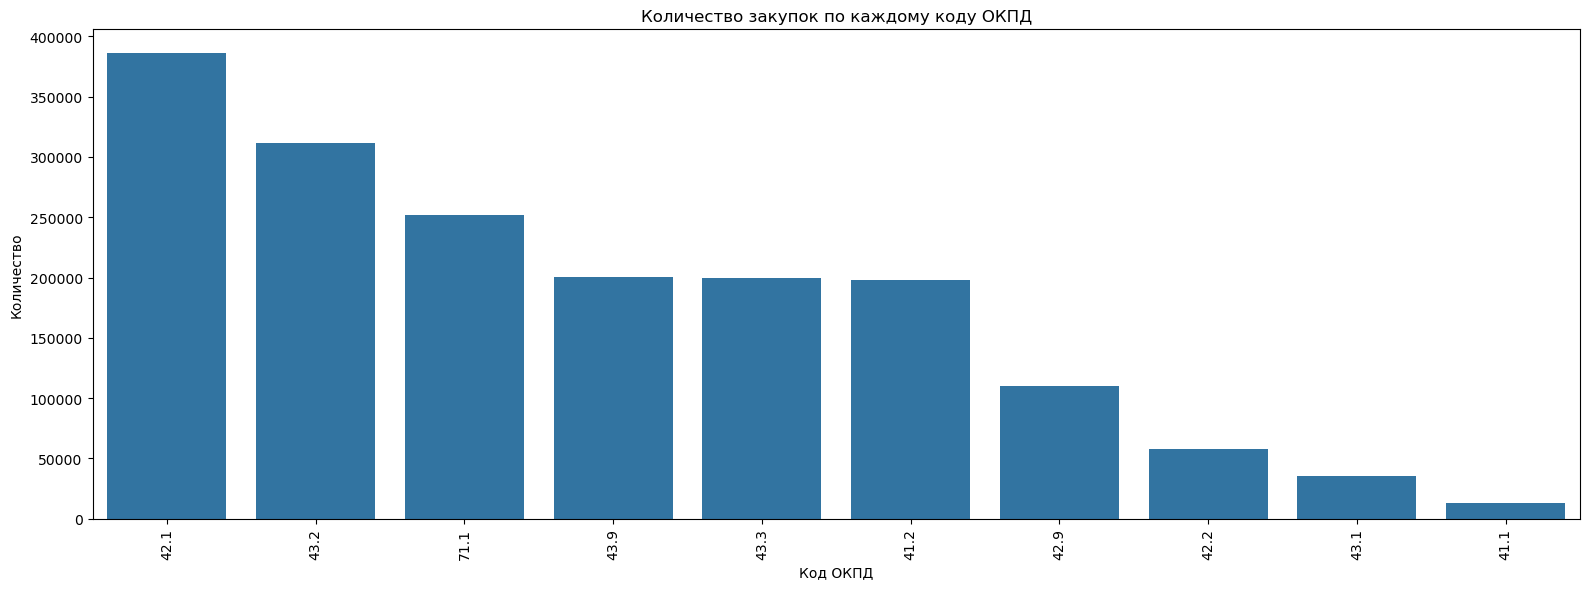

In [35]:
plt.figure(figsize=(16, 6))
sns.countplot(data=df, x='object_code', order=df['object_code'].value_counts().index)
plt.title('Количество закупок по каждому коду ОКПД')
plt.xlabel('Код ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

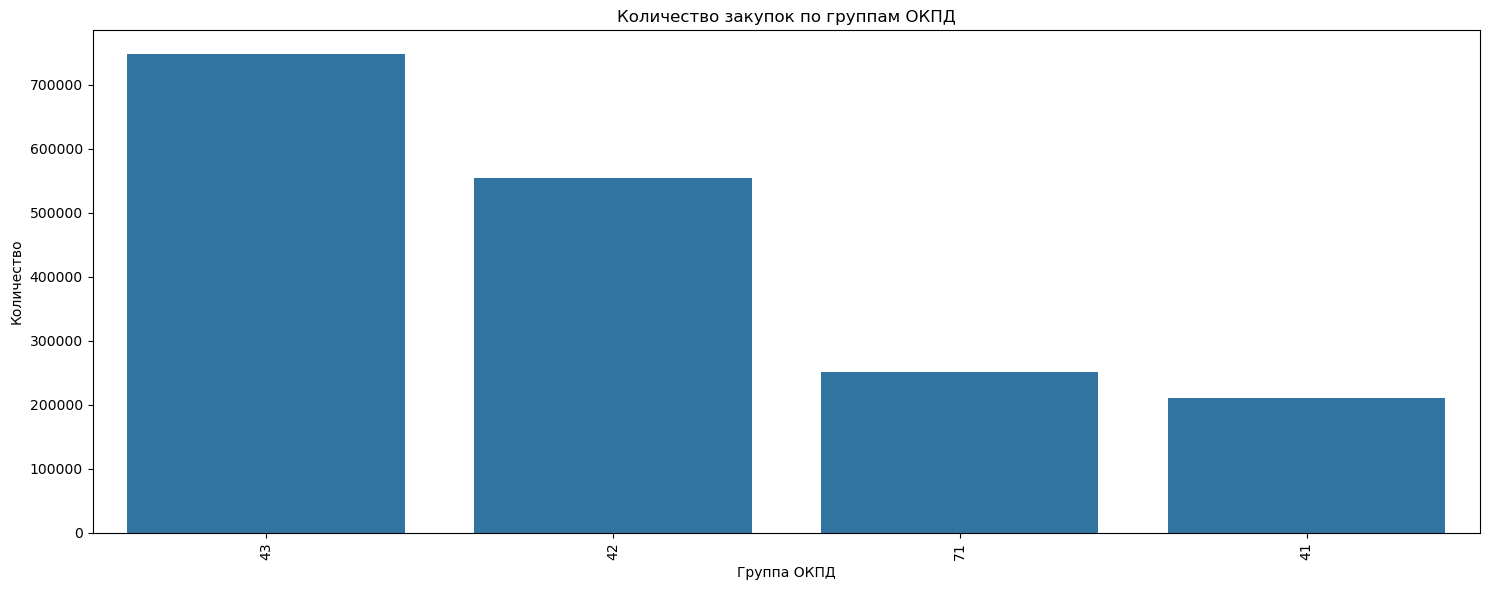

In [36]:
df['code_int'] = df['object_code'].apply(lambda x: '.'.join(x.split('.')[:1]))

plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='code_int', order=df['code_int'].value_counts().index)
plt.title('Количество закупок по группам ОКПД')
plt.xlabel('Группа ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [37]:
df.head(4)

,contract_number,object_name,cost,object_code,code_int
0,1026802173421000064,прочая закупка услуг (услуги по монтажу и пуск...,277671.00,43.2,43
1,1027401123721000132,выполнение работ по текущему ремонту заполнени...,723924.00,43.3,43
2,1027401123721000133,выполнение работ по текущему ремонту заполнени...,318484.80,43.3,43
3,1027401123721000134,выполнение работ по текущему ремонту заполнени...,1066988.40,43.3,43


In [38]:
grouped_data = df.groupby('object_code')['object_code'].unique()
grouped_data

object_code
41.1    [41.1]
41.2    [41.2]
42.1    [42.1]
42.2    [42.2]
42.9    [42.9]
43.1    [43.1]
43.2    [43.2]
43.3    [43.3]
43.9    [43.9]
71.1    [71.1]
Name: object_code, dtype: object

In [39]:
query = '''object_code.str.contains("41.") or object_code.str.contains("42.") or object_code.str.contains("43.") or object_code == "71.1" '''
df = df.query(query, engine='python')

In [40]:
df.describe()

,contract_number,object_name,cost,object_code,code_int
count,1764006,1764006,1764006,1764006,1764006
unique,1529994,1245646,1123238,10,4
top,3434530185621000050,Приобретение у застройщика жилого помещения (о...,\N,42.1,43
freq,238,4271,22549,386497,747430


In [41]:
df.head(4)

,contract_number,object_name,cost,object_code,code_int
0,1026802173421000064,прочая закупка услуг (услуги по монтажу и пуск...,277671.00,43.2,43
1,1027401123721000132,выполнение работ по текущему ремонту заполнени...,723924.00,43.3,43
2,1027401123721000133,выполнение работ по текущему ремонту заполнени...,318484.80,43.3,43
3,1027401123721000134,выполнение работ по текущему ремонту заполнени...,1066988.40,43.3,43


Укорачиваю датафрейм для скорости

In [42]:
n = 150000
df = df.sample(n)

In [43]:
df.describe()

,contract_number,object_name,cost,object_code,code_int
count,150000,150000,150000,150000,150000
unique,147706,133919,123266,10,4
top,3434530185621000050,Приобретение у застройщика жилого помещения (о...,\N,42.1,43
freq,24,383,2009,32616,63713


In [44]:
! pip install scikit-learn
! pip install nltk
! pip install pymorphy2
! pip install requests
! pip install gensim
! pip install pymystem3
! pip install matplotlib

In [45]:
import pandas as pd
import numpy as np

Чистим от чисел и латиницы

In [46]:
def clear_text(text):
    lst = [char for char in text if 1039 < ord(text[0])]
    return ''.join(lst)

In [47]:
df['object_name'] = df['object_name'].apply(lambda x: clear_text(x))
df = df[df["object_name"] != ""]

In [48]:
df.sample(3)

,contract_number,object_name,cost,object_code,code_int
1405464,3301702225518000005,"Выполнение работ по ремонту крыльца, дорожки и...",605816.72,43.9,43
1055586,2290106893921000030,Текущий ремонт автоматической установки пожар...,3159516.78,43.2,43
1082858,3471002623319000011,Создание мест (площадок) накопления твердых ко...,3309899.35,42.9,42


In [49]:
df.describe()

,contract_number,object_name,cost,object_code,code_int
count,147806,147806,147806,147806,147806
unique,145552,131913,121436,10,4
top,3434530185621000050,Приобретение у застройщика жилого помещения (о...,\N,42.1,43
freq,24,383,1986,32140,62732


Токенизация, лемматизация, очистка пунктуации и от стоп-слов

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import download
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn  # Проверить необходимость

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier  # SVM модель
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from gensim.models import Word2Vec
from collections import defaultdict, Counter
import openpyxl

In [51]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
from nltk import download
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter
from nltk.corpus import wordnet as wn  # Проверить необходимость
from nltk.corpus import stopwords

#print(stopwords.words('russian'))

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

stemmer = nltk.stem.snowball.RussianStemmer()
word_lemmatized = WordNetLemmatizer()


class NLP:
  
  def __init__(self, __df):
     self.df = __df

  def tokening(self):
     self.df['data'] =  [word_tokenize(entry.lower()) for entry in self.df['object_name']]

  def lammatize(self, word, tag):
     return word_lemmatized.lemmatize(word, tag_map[tag])

  def steming(self, word_final):
     return stemmer.stem(word_final)

  def fit(self): 
    self.tokening()
    for index, entry in zip(self.df["data"].index, self.df['data']):
        final_words = []
        for word, tag in pos_tag(entry):
            if word not in stopwords.words("russian") and word.isalpha():
                word_final = self.lammatize(word, tag[0])
                word_final = self.steming(word_final)
                final_words.append(word_final)
        self.df.loc[index, "data_final"] = str(final_words)
    return self.df

nlp = NLP(df)
df_final = nlp.fit()

In [53]:
df_final.head(3)

,contract_number,object_name,cost,object_code,code_int,data,data_final
1736741,3232800558922000559,Приобретение объекта недвижимого имущества в г...,3956666.66,41.2,41,"[приобретение, объекта, недвижимого, имущества...","['приобретен', 'объект', 'недвижим', 'имуществ..."
856093,3671000424020000004,Выполнение работ по восстановлению Братской мо...,508315.20,43.9,43,"[выполнение, работ, по, восстановлению, братск...","['выполнен', 'работ', 'восстановлен', 'братск'..."
1175974,2860600285017000083,Выполнение работ по текущему ремонту системы о...,195443.40,43.2,43,"[выполнение, работ, по, текущему, ремонту, сис...","['выполнен', 'работ', 'текущ', 'ремонт', 'сист..."


ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZz

In [54]:
df = df.dropna()
data, object_code, data_final = df["data"], df["object_code"], df["data_final"]

In [55]:
df

,contract_number,object_name,cost,object_code,code_int,data,data_final
1736741,3232800558922000559,Приобретение объекта недвижимого имущества в г...,3956666.66,41.2,41,"[приобретение, объекта, недвижимого, имущества...","['приобретен', 'объект', 'недвижим', 'имуществ..."
856093,3671000424020000004,Выполнение работ по восстановлению Братской мо...,508315.20,43.9,43,"[выполнение, работ, по, восстановлению, братск...","['выполнен', 'работ', 'восстановлен', 'братск'..."
1175974,2860600285017000083,Выполнение работ по текущему ремонту системы о...,195443.40,43.2,43,"[выполнение, работ, по, текущему, ремонту, сис...","['выполнен', 'работ', 'текущ', 'ремонт', 'сист..."
741089,1770989550920002169,Оказание услуг по техническому обслуживанию и ...,256506.24,43.2,43,"[оказание, услуг, по, техническому, обслуживан...","['оказан', 'услуг', 'техническ', 'обслуживан',..."
1629119,3531200105522000049,Выполнение работ по ремонту участка автомобиль...,1809025.00,42.1,42,"[выполнение, работ, по, ремонту, участка, авто...","['выполнен', 'работ', 'ремонт', 'участк', 'авт..."
...,...,...,...,...,...,...,...
121713,2632000440719000112,Выполнение работ по текущему ремонту помещений...,1699927.82,43.3,43,"[выполнение, работ, по, текущему, ремонту, пом...","['выполнен', 'работ', 'текущ', 'ремонт', 'поме..."
941576,2772231528120000007,Выполнение работ по устройству навеса для базы...,1000000.00,41.2,41,"[выполнение, работ, по, устройству, навеса, дл...","['выполнен', 'работ', 'устройств', 'навес', 'б..."
1032381,2410105990717000126,выполнение работ по текущему ремонту душевой ...,90340.00,43.3,43,"[выполнение, работ, по, текущему, ремонту, душ...","['выполнен', 'работ', 'текущ', 'ремонт', 'душе..."
1056601,2594803504221000314,"Выборочный ремонт здания ПЧ-70, расположенной ...",1356270.00,43.9,43,"[выборочный, ремонт, здания, пч-70, ,, располо...","['выборочн', 'ремонт', 'здан', 'расположен', '..."


In [56]:
data

1736741    [приобретение, объекта, недвижимого, имущества...
856093     [выполнение, работ, по, восстановлению, братск...
1175974    [выполнение, работ, по, текущему, ремонту, сис...
741089     [оказание, услуг, по, техническому, обслуживан...
1629119    [выполнение, работ, по, ремонту, участка, авто...
                                 ...                        
121713     [выполнение, работ, по, текущему, ремонту, пом...
941576     [выполнение, работ, по, устройству, навеса, дл...
1032381    [выполнение, работ, по, текущему, ремонту, душ...
1056601    [выборочный, ремонт, здания, пч-70, ,, располо...
1013738    [выполнение, работ, по, благоустройству, терри...
Name: data, Length: 147806, dtype: object

In [57]:
object_code

1736741    41.2
856093     43.9
1175974    43.2
741089     43.2
1629119    42.1
           ... 
121713     43.3
941576     41.2
1032381    43.3
1056601    43.9
1013738    42.9
Name: object_code, Length: 147806, dtype: string

In [58]:
data_final

1736741    ['приобретен', 'объект', 'недвижим', 'имуществ...
856093     ['выполнен', 'работ', 'восстановлен', 'братск'...
1175974    ['выполнен', 'работ', 'текущ', 'ремонт', 'сист...
741089     ['оказан', 'услуг', 'техническ', 'обслуживан',...
1629119    ['выполнен', 'работ', 'ремонт', 'участк', 'авт...
                                 ...                        
121713     ['выполнен', 'работ', 'текущ', 'ремонт', 'поме...
941576     ['выполнен', 'работ', 'устройств', 'навес', 'б...
1032381    ['выполнен', 'работ', 'текущ', 'ремонт', 'душе...
1056601    ['выборочн', 'ремонт', 'здан', 'расположен', '...
1013738    ['выполнен', 'работ', 'благоустройств', 'терри...
Name: data_final, Length: 147806, dtype: object

Создаем словарь групп ОКПД2

In [59]:
# Создадим словарь кодов ОКПД2 и соответствующих им рубрик классификатора
OKPD2_to_Labels = {
    '41.1': 'Документация проектная для строительства',
    '41.2': 'Здания и работы по возведению зданий',
    '42.1': 'Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог',
    '42.2': 'Сооружения и строительные работы по строительству инженерных коммуникаций',
    '42.9': 'Сооружения и строительные работы по строительству прочих гражданских сооружений',
    '43.1': 'Работы по сносу зданий и сооружений и по подготовке строительного участка',
    '43.2': 'Работы электромонтажные; работы по монтажу водопроводных и канализационных систем и прочие строительно-монтажные работы',
    '43.3': 'Работы завершающие и отделочные в зданиях и сооружениях',
    '43.9': 'Работы строительные специализированные прочие',
    '71.1': 'Услуги в области архитектуры; инженерно-технического проектирования и связанные технические консультативные услуги'
}

In [60]:
# Определим функцию для преобразования кодов ОКПД2 в текстовые метки рубрик классификатора
def convert_OKPD2_to_text_labels(code_OKPD2):
  return [OKPD2_to_Labels.get(c) for c in str(code_OKPD2).split(',') if c in OKPD2_to_Labels]

In [61]:
# Создадим словарь рубрик классификатора и соответствующих им кодов ОКПД2
Labels_to_OKPD2 = {v: k for k, v in OKPD2_to_Labels.items()}

In [62]:
# Промаркируем датафрейм метками рубрик
df['text_Labels'] = df['object_code'].apply(convert_OKPD2_to_text_labels)

In [63]:
df.head(13)

,contract_number,object_name,cost,object_code,code_int,data,data_final,text_Labels
1736741,3232800558922000559,Приобретение объекта недвижимого имущества в г...,3956666.66,41.2,41,"[приобретение, объекта, недвижимого, имущества...","['приобретен', 'объект', 'недвижим', 'имуществ...",[Здания и работы по возведению зданий]
856093,3671000424020000004,Выполнение работ по восстановлению Братской мо...,508315.20,43.9,43,"[выполнение, работ, по, восстановлению, братск...","['выполнен', 'работ', 'восстановлен', 'братск'...",[Работы строительные специализированные прочие]
1175974,2860600285017000083,Выполнение работ по текущему ремонту системы о...,195443.40,43.2,43,"[выполнение, работ, по, текущему, ремонту, сис...","['выполнен', 'работ', 'текущ', 'ремонт', 'сист...",[Работы электромонтажные; работы по монтажу во...
741089,1770989550920002169,Оказание услуг по техническому обслуживанию и ...,256506.24,43.2,43,"[оказание, услуг, по, техническому, обслуживан...","['оказан', 'услуг', 'техническ', 'обслуживан',...",[Работы электромонтажные; работы по монтажу во...
1629119,3531200105522000049,Выполнение работ по ремонту участка автомобиль...,1809025.00,42.1,42,"[выполнение, работ, по, ремонту, участка, авто...","['выполнен', 'работ', 'ремонт', 'участк', 'авт...",[Дороги автомобильные и железные; строительные...
810284,3182400171019000026,№ зз-19018-19 Выполнение комплексных кадастров...,178500.00,71.1,71,"[№, зз-19018-19, выполнение, комплексных, када...","['выполнен', 'комплексн', 'кадастров', 'работ'...",[Услуги в области архитектуры; инженерно-техни...
902881,3382100781219000017,Работы по ремонту забора,600000.00,43.2,43,"[работы, по, ремонту, забора]","['работ', 'ремонт', 'забор']",[Работы электромонтажные; работы по монтажу во...
490627,3434801069317000092,Выполнение кадастровых работ,28666.67,71.1,71,"[выполнение, кадастровых, работ]","['выполнен', 'кадастров', 'работ']",[Услуги в области архитектуры; инженерно-техни...
70806,2770327661518000017,Выполнение проектно-изыскательских работ по об...,19480250.58,71.1,71,"[выполнение, проектно-изыскательских, работ, п...","['выполнен', 'работ', 'объект', 'капитальн', '...",[Услуги в области архитектуры; инженерно-техни...
74615,3380700027617000159,Выполнение работ по разработке проектно-сметно...,4412373.00,71.1,71,"[выполнение, работ, по, разработке, проектно-с...","['выполнен', 'работ', 'разработк', 'документац...",[Услуги в области архитектуры; инженерно-техни...


In [64]:
# Для многоклассовой классификации используем бинарное представление текстовых меток рубрик
mlb_Labels = MultiLabelBinarizer()
y = mlb_Labels.fit_transform(df['text_Labels'])

In [65]:
y

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [66]:
# Зададим размер обучающей выборки в 80%, тестовой выборки - 20%
X_train, X_test, y_train, y_test = train_test_split(df['data_final'], y, test_size=0.2, random_state=42)

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import download
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn  # Проверить необходимость

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier  # SVM модель
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from gensim.models import Word2Vec
from collections import defaultdict, Counter
import openpyxl

In [68]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
tfidf = TfidfVectorizer(max_features=1700, min_df=5, max_df=0.7, stop_words=stopwords.words('russian'))
tfidf_X = tfidf.fit_transform(data_final).toarray()
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_X,
                                                                            y,
                                                                            test_size=0.2,
                                                                            random_state=0)

Метод логистической регрессии. На выборке 150 тысяч записей модель обучается около минуты

In [70]:
model = MultiOutputClassifier(LogisticRegression(max_iter=1000))

Сслучайный лес. На выборке 150 тысяч записей модель обучается за 1 час 15 минут# model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)Гм градиентный бустинг. На выборке 150 тысяч записей модель обучается за 18 мин
# model = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=100, random_state=4Муем метод опорных векторов. На выборке 150 тысяч записей модель обучается около миты
# model = OneVsRestClassifier(CalibratedClassifierCV(LinearSVНьзуем наивный байесовский классификатор. На выборке 150 тысяч записей модель обучается за несколько кунд
# model = OneVsRestClassifier(Multinomiпользуем XGBoost. На выборке 150 тысяч записей модель обучается за 3,минуты
# model = MultiOutputClassifier(XGBClassifier(n_estimators=100, random_sНспользуем нейронные сети. На выборке 150 тысяч записей модель обучается оло часа
# model = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(10), max_iter=100, random_state=42))

In [71]:
# Построим пайплайн модели обучения
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clsf', model)
])

In [72]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, max_features=1700, min_df=5,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('clsf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [73]:
# На обучающей выборке
train_predictions = pipeline.predict(X_train)
train_report = classification_report(y_train, train_predictions, target_names=mlb_Labels.classes_)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Метрики оценки качества на обучающей выборке:")
print(train_report)
print(f"Точность (Accuracy) на обучающей выборке равна {train_accuracy:.2f}")

Метрики оценки качества на обучающей выборке:
                                                                                                                         precision    recall  f1-score   support

                                                                               Документация проектная для строительства       0.24      0.03      0.05       897
             Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог       0.92      0.88      0.90     25768
                                                                                   Здания и работы по возведению зданий       0.85      0.46      0.60     13287
                                                                Работы завершающие и отделочные в зданиях и сооружениях       0.73      0.55      0.62     13444
                                              Работы по сносу зданий и сооружений и по подготовке строительного участка       0.91      0.52      0.

In [74]:
# На тестовой выборке
test_predictions = pipeline.predict(X_test)
test_report = classification_report(y_test, test_predictions, target_names=mlb_Labels.classes_)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Метрики оценки качества на тестовой выборке:")
print(test_report)
print(f"Точность (Accuracy) на тестовой выборке равна {test_accuracy:.2f}")

Метрики оценки качества на тестовой выборке:
                                                                                                                         precision    recall  f1-score   support

                                                                               Документация проектная для строительства       0.26      0.04      0.07       210
             Дороги автомобильные и железные; строительные работы по строительству автомобильных дорог и железных дорог       0.92      0.87      0.90      6372
                                                                                   Здания и работы по возведению зданий       0.82      0.46      0.59      3371
                                                                Работы завершающие и отделочные в зданиях и сооружениях       0.71      0.53      0.60      3346
                                              Работы по сносу зданий и сооружений и по подготовке строительного участка       0.90      0.55      0.6

In [75]:
joblib.dump(pipeline, 'fz_classification_model.pkl')

['fz_classification_model.pkl']

ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ

In [76]:
# Загружаем сохраненную модель
pipeline = joblib.load('fz_classification_model.pkl')

In [77]:
# Определим функцию для классификации нового контракта
def classify_new_contract(Subject_of_new_contract):
  lemmatized_Subject = lemmatize_Subject(Subject_of_new_contract)
  prediction = pipeline.predict([lemmatized_Subject])
  labels = mlb_Labels.inverse_transform(prediction)
  return labels[0]

In [ ]:
new_contract = input("Введите предмет закупки: ")
predicted_Subject = classify_new_contract(new_contract)
if len(predicted_Subject) != 0:
  for key in Labels_to_OKPD2:
    if key == predicted_Subject[0]:
      predicted_OKPD2 = Labels_to_OKPD2[key]
      print(f"Результат классификации: ОКПД2 - {predicted_OKPD2}, рубрика - {predicted_Subject[0]}")
else: print(f"Предмет закупки '{new_contract}' не классифицирован")